In [150]:
import keras.utils
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Import data

In [151]:
variable = {'phF': 0, 'MF': 1}['phF'] # TODO: for now just classify one variable

In [152]:
path = './Output'

In [153]:
# dimensions
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(path) if p[:14] == 'feature_vector']), \
                             *np.load(path + '/feature_vector0.npy').shape

# metadata (subjectID etc.)
with open(path + '/metadata.txt') as f:
    metadata = f.read()
metadata = json.loads(metadata.replace('\'', '\"').replace('False', 'false').replace('True', 'true')) # doesn't accept other chars

# Train/validation split

In [154]:
VALIDATION_SIZE = 0.2

In [155]:
# use unaugmented data for validation set
non_augmented = [i for i, meta in enumerate(metadata) if meta['augmented'] == False]

validation_indices = np.random.choice(non_augmented, int(N * VALIDATION_SIZE), replace=False)
training_indices = np.delete(np.arange(N), validation_indices)

In [156]:
print(f'Training set: {len(training_indices)}')
print(f'Validation set: {len(validation_indices)}')

Training set: 2464
Validation set: 615


# Define data generator

In [157]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=float) # TODO: int for non-logits

        # load individual datapoints
        for i, index in enumerate(indices):
            X[i, ] = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[variable] # TODO: for now just one variable

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

# Upsampling

In [158]:
UPSAMPLING_STRATEGY = 'nothing' # ['repeat', 'nothing']

In [159]:
def check_imbalance(path_to_labels, indices):
    """Returns indices of positives/negatives"""
    y = np.empty((len(indices), 2), dtype=int)
    for i, index in enumerate(indices):
        y[i, ] = np.load(path_to_labels + f'/labels{index}.npy', allow_pickle=True)

    positives = np.where(y[:, variable] == 1)[0] # TODO: for now just one variable
    negatives = np.where(y[:, variable] == 0)[0] # TODO: for now just one variable

    return np.array(indices)[positives], np.array(indices)[negatives]


# validation set
positives, negatives = check_imbalance(path, validation_indices)
print(f'validation: (+: {len(positives)}, -: {len(negatives)})')

# training set
positives, negatives = check_imbalance(path, training_indices)
print(f'train_set: (+: {len(positives)}, -: {len(negatives)})')

sample_weight = len(negatives) / len(positives) # for weighted cross-entropy

# upsampling training set
if UPSAMPLING_STRATEGY == 'repeat':
    upsampled_indices = np.random.choice(negatives, size=(len(positives) - len(negatives)), replace=True) # with replacement
    upsampled_indices = np.append(upsampled_indices, np.arange(N))
    training_indices = np.append(positives, negatives) # update

    positives, negatives = check_imbalance(path, upsampled_indices)
    print(f'train_set (upsampled): (+: {len(positives)}, -: {len(negatives)})')
if UPSAMPLING_STRATEGY == 'nothing':
    pass

print(f'\nWeighted loss function: weight = {sample_weight}')

validation: (+: 448, -: 167)
train_set: (+: 1877, -: 587)

Weighted loss function: weight = 0.31273308470964306


# CNN

Data generators

In [160]:
training_batch_generator = DataGenerator(data_path=path, indices_dataset=training_indices, batch_size=128)
validation_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=32) # TODO: use test set to avoid mixing

Model

In [161]:
# wrapper functions
def weighted_cross_entropy(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, weight
        )
        return loss
    return weighted_cross_entropy_with_logits

class accuracy_with_logits(tf.keras.metrics.Accuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(accuracy_with_logits, self).update_state(y_true, y_pred, sample_weight)

class recall_with_logits(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(recall_with_logits, self).update_state(y_true, y_pred, sample_weight)

class precision_with_logits(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(precision_with_logits, self).update_state(y_true, y_pred, sample_weight)

In [162]:
model = models.Sequential(name='custom_CNN')

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(370, 100, 30), padding='same', name='conv1-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1-2'))
model.add(BatchNormalization(name='batch_norm1')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool1'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2-2'))
model.add(BatchNormalization(name='batch_norm2')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool2'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-2'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-3'))
model.add(BatchNormalization(name='batch_norm3')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool3'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-3'))
model.add(BatchNormalization(name='batch_norm4')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool4'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-3'))
model.add(BatchNormalization(name='batch_norm5')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool5'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-3'))
model.add(BatchNormalization(name='batch_norm6')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool6'))

model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2', name='dense1'))
model.add(Dropout(0.4, name='dropout1')) # TODO: worth it? parameter scale adequate?
model.add(Dense(64, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2', name='dense2'))
model.add(Dropout(0.3, name='dropout2')) # TODO: worth it? parameter scale adequate?
model.add(Dense(1, kernel_regularizer='l2', name='dense3'))

#model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
model.compile(optimizer=Adam(learning_rate=1e-5), loss=weighted_cross_entropy(sample_weight), metrics=[accuracy_with_logits(),
                                                                                              recall_with_logits(),
                                                                                              precision_with_logits()])

model.summary()

Model: "custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1-1 (Conv2D)             (None, 370, 100, 16)      4336      
_________________________________________________________________
conv1-2 (Conv2D)             (None, 370, 100, 16)      2320      
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 370, 100, 16)      64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 185, 50, 16)       0         
_________________________________________________________________
conv2-1 (Conv2D)             (None, 185, 50, 16)       2320      
_________________________________________________________________
conv2-2 (Conv2D)             (None, 185, 50, 16)       2320      
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 185, 50, 16)       6

Training

In [163]:
%%time
# save best performing model
checkpoint_path = './temp/checkpoint_model'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            save_best_only=True)

# train
history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=80,
                              callbacks=[model_checkpoint_callback])

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
19/19 [==============================] - 23s 1s/step - loss: 1.0698 - accuracy: 0.4926 - recall_with_logits_7: 0.4857 - precision_with_logits_7: 0.7604 - val_loss: 1.0741 - val_accuracy: 0.2714 - val_recall_with_logits_7: 0.0000e+00 - val_precision_with_logits_7: 0.0000e+00
Epoch 2/80
19/19 [==============================] - 21s 1s/step - loss: 1.0650 - accuracy: 0.5012 - recall_with_logits_7: 0.4965 - precision_with_logits_7: 0.7667 - val_loss: 1.0726 - val_accuracy: 0.2747 - val_recall_with_logits_7: 0.0000e+00 - val_precision_with_logits_7: 0.0000e+00
Epoch 3/80
19/19 [==============================] - 20s 1s/step - loss: 1.0623 - accuracy: 0.4753 - recall_with_logits_7: 0.4668 - precision_with_logits_7: 0.7493 - val_loss: 1.0697 - val_accuracy: 0.2747 - val_recall_with_logits_7: 0.0000e+00 - val_precision_with_logits_7: 0.0000e+00
Epoch 4/80
19/19 [==============================] - 19s 1s/step - loss: 1.0574 - accuracy: 0.4938 - recall_with_logits_7: 0.4830 - precision_w

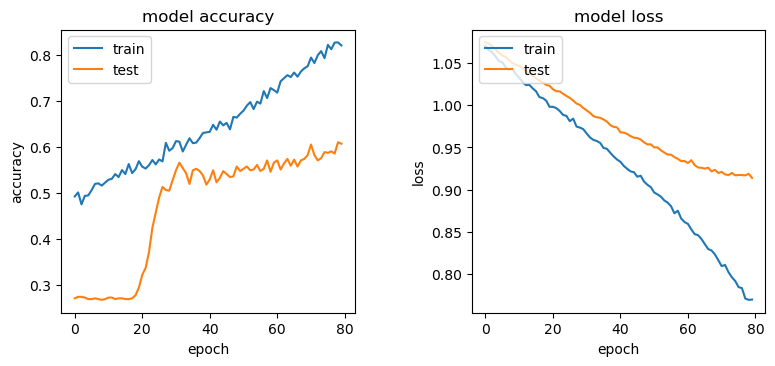

In [164]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# metric
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# Evaluation

In [165]:
# load best performing model
model.load_weights(checkpoint_path)

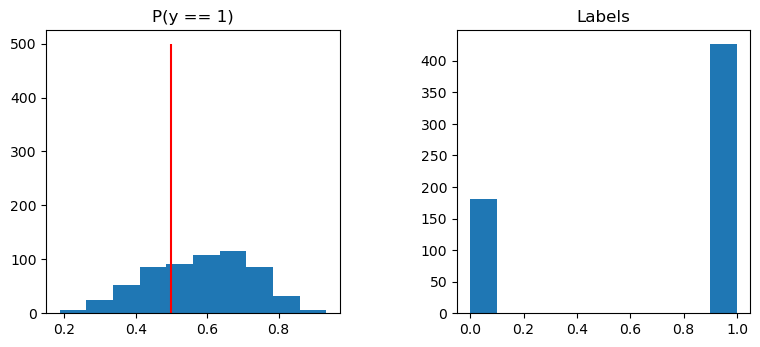

In [166]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = model.predict(validation_batch_generator)
y_pred = tf.math.sigmoid(y_pred).numpy() # TODO: for logits

# for probs
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

In [167]:
# load test data
print(f'Test set: {len(validation_indices)}') # TODO: separate test-set

test_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=1) # TODO: separate test-set
y_test = np.empty(0)
for batch_index in range(len(test_batch_generator)):
    _, y_test_batch = test_batch_generator.__getitem__(batch_index)
    y_test = np.append(y_test, y_test_batch)

Test set: 615


accuracy: 0.6065040650406504
balanced accuracy: 0.5177034324208725
f1 (weighted): 0.6119210220673635
recall (weighted): 0.6065040650406504
precision (weighted): 0.6180382168120406


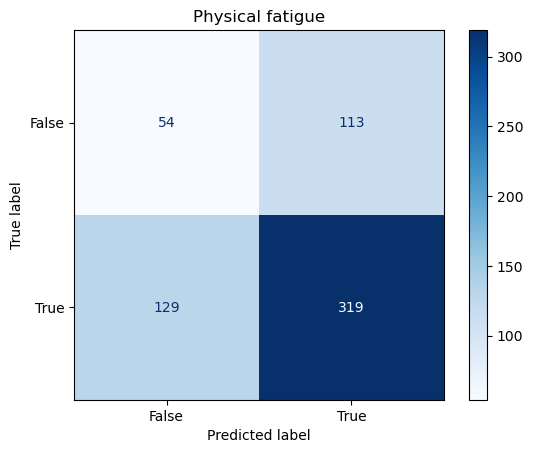

In [168]:
# classification metrics
# predict
y_test_pred = model.predict(test_batch_generator)
y_test_pred = tf.math.sigmoid(y_test_pred).numpy() # TODO: for logits
y_test_pred = np.round(y_test_pred)

# evaluate
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

# Continue training

In [169]:
%%time
# save best performing model
checkpoint_path = './temp/checkpoint_model2'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            save_best_only=True)

# train
history2 = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=20,
                              callbacks=[model_checkpoint_callback])

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
19/19 [==============================] - 35s 2s/step - loss: 0.7613 - accuracy: 0.8335 - recall_with_logits_7: 0.8343 - precision_with_logits_7: 0.9404 - val_loss: 0.9159 - val_accuracy: 0.6036 - val_recall_with_logits_7: 0.6966 - val_precision_with_logits_7: 0.7452
Epoch 2/20
19/19 [==============================] - 20s 1s/step - loss: 0.7548 - accuracy: 0.8368 - recall_with_logits_7: 0.8369 - precision_with_logits_7: 0.9422 - val_loss: 0.9182 - val_accuracy: 0.6118 - val_recall_with_logits_7: 0.7036 - val_precision_with_logits_7: 0.7476
Epoch 3/20
19/19 [==============================] - 21s 1s/step - loss: 0.7448 - accuracy: 0.8516 - recall_with_logits_7: 0.8486 - precision_with_logits_7: 0.9509 - val_loss: 0.9142 - val_accuracy: 0.6086 - val_recall_with_logits_7: 0.6968 - val_precision_with_logits_7: 0.7476
Epoch 4/20
19/19 [==============================] - 21s 1s/step - loss: 0.7391 - accuracy: 0.8606 - recall_with_logits_7: 0.8595 - precision_with_logits_7: 0.9527 - v

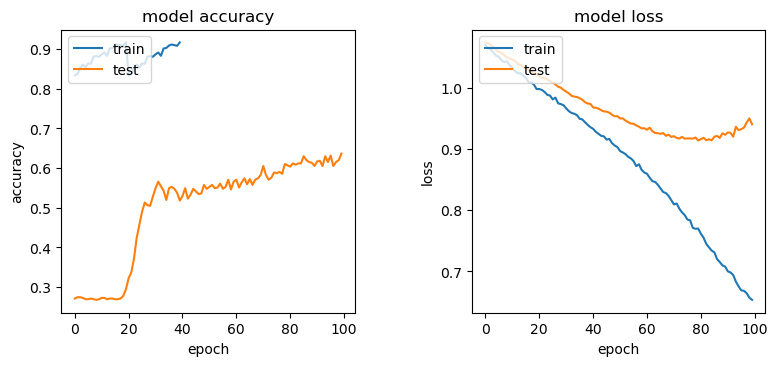

In [194]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

full_history_acc = history.history['accuracy'] + history2.history['accuracy']
full_history_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']
full_history_loss = history.history['loss'] + history2.history['loss']
full_history_val_loss = history.history['val_loss'] + history2.history['val_loss']

# metric
plt.subplot(1, 2, 1)
plt.plot(full_history_acc)
plt.plot(full_history_val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(full_history_loss)
plt.plot(full_history_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()